**Iskemi Data Examples**

In [50]:
file_path = "/Users/esmasert/Desktop/TeknoFest/Veriler/TRAINING/ISKEMI/DICOM/10354.dcm"

In [51]:
import pydicom
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage
from skimage import morphology

In [52]:
medical_image = pydicom.read_file(file_path)
print(medical_image)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.278.3.3607802718.431.1586836327.961.20
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.30071.8
(0002, 0013) Implementation Version Name         SH: 'fo-dicom 4.0.0'
(0002, 0016) Source Application Entity Title     AE: 'TEKNOYPYZEKA'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0018, 0050) Slice Thickness                     DS: "5.0"
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                       

In [53]:
image = medical_image.pixel_array
print(image.shape)

(512, 512)


In [54]:
print(image.min())
print(image.max())

-2000
2805


In [55]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

In [56]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [57]:
def load_and_plot_image(file_path, save=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    print(image.shape)
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)
    bone_image = window_image(hu_image, 400, 1000)
    
    plt.figure(figsize=(20, 10))
    plt.style.use('grayscale')

    plt.subplot(151)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(152)
    plt.imshow(hu_image)
    plt.title('Hu image')
    plt.axis('off')

    plt.subplot(153)
    plt.imshow(brain_image)
    plt.title('brain image')
    plt.axis('off')

    plt.subplot(154)
    plt.imshow(bone_image)
    plt.title('bone image')
    plt.axis('off')
    
    if save:
        mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-original.png'), image)
        mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-hu_image.png'), hu_image)
        mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-brain_image.png'), brain_image)
        mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-bone_image.png'), bone_image)

**Iskemi ornek**

(512, 512)


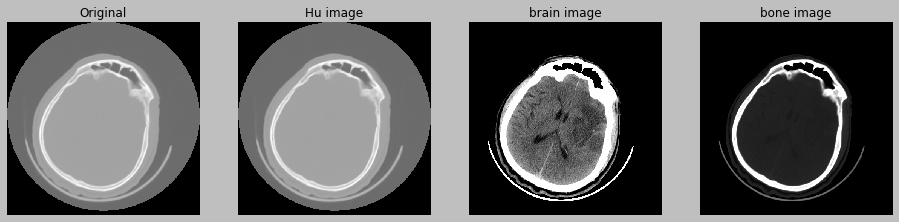

In [59]:
iskemiPath = file_path
load_and_plot_image(iskemiPath)

**Kanama ornek**

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


(512, 512)


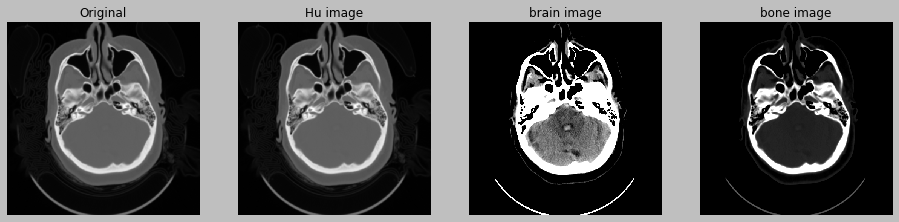

In [60]:
kanamaPath = "/Users/esmasert/Desktop/TeknoFest/Veriler/TRAINING/KANAMA/DICOM/10997.dcm"
load_and_plot_image(kanamaPath)

**Kanama Yok Ornek**

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (13-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


(512, 512)


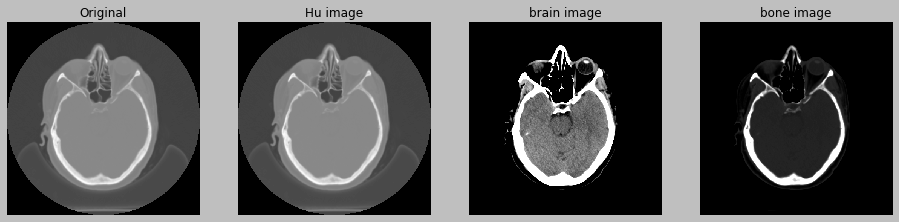

In [61]:
kanamaYokPath = "/Users/esmasert/Desktop/TeknoFest/Veriler/TRAINING/INMEYOK/DICOM/10591.dcm"
load_and_plot_image(kanamaYokPath)

# Improving Images

In [62]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)

    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 5x5, the pixel belongs to the same class
    
    # We can instead use a circule using: morphology.disk(2)
    # In this case the pixel belongs to the same class if it's between the origin
    # and the radius
    
    segmentation = morphology.dilation(brain_image, np.ones((5, 5)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    
    # We don't use the first class since it's the background
    label_count[0] = 0
    
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((5, 5)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    
    # Since the the pixels in the mask are zero's and one's
    # We can multiple the original image to only keep the brain region
    masked_image = mask * brain_image

    if display:
        plt.figure(figsize=(15, 2.5))
        plt.subplot(141)
        plt.imshow(brain_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title('Final Image')
        plt.axis('off')
    
    return masked_image

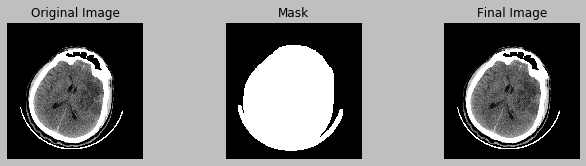

In [63]:
_ = remove_noise(iskemiPath, display=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


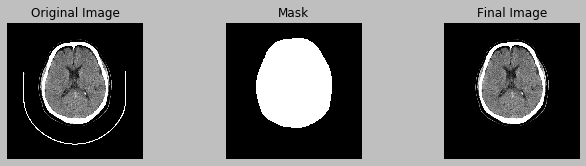

In [65]:
iskemiPathh = "/Users/esmasert/Desktop/TeknoFest/Veriler/TRAINING/ISKEMI/DICOM/10355.dcm"
_ = remove_noise(iskemiPathh, display=True)

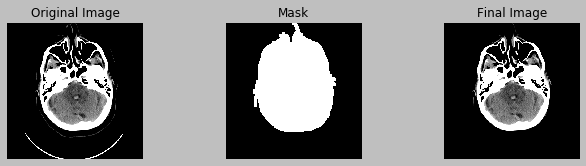

In [66]:
_ = remove_noise(kanamaPath, display=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (13-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


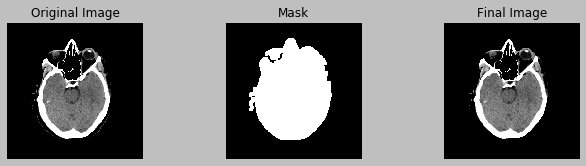

In [67]:
_ = remove_noise(kanamaYokPath, display=True)

In [68]:
def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    return croped_image

In [69]:
kanamaPath2 = "/Users/esmasert/Desktop/TeknoFest/Veriler/TRAINING/KANAMA/DICOM/10094.dcm"

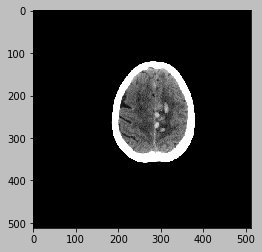

In [70]:
final_image = remove_noise(kanamaPath2)
plt.imshow(final_image)

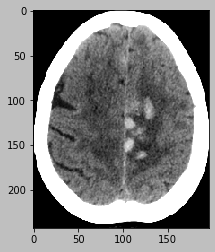

In [71]:
final_image = crop_image(final_image)
plt.imshow(final_image)

In [72]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) / 2)
    pad_top = int((new_height - height) / 2)
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

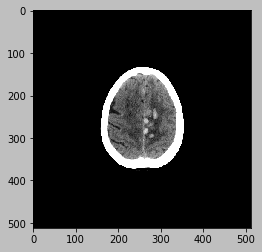

In [73]:
final_image = add_pad(final_image)
plt.imshow(final_image)

**Baska Bir Ornek (Inme Yok)**

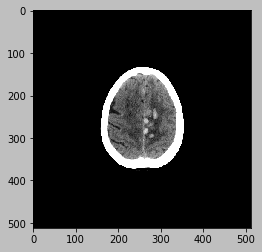

In [79]:
pathh = "/Users/esmasert/Desktop/TeknoFest/Veriler/TRAINING/INMEYOK/DICOM/11126.dcm"

final_image2 = remove_noise(pathh)
plt.imshow(final_image)



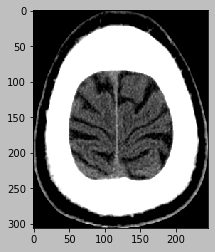

In [80]:
final_image2 = crop_image(final_image2)
plt.imshow(final_image2)

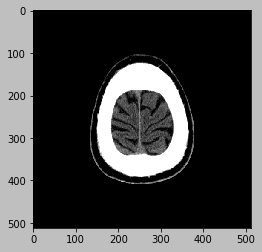

In [81]:
final_image2 = add_pad(final_image2)
plt.imshow(final_image2)